# Tropical Cyclone Intensity classification
In this notebook we attempt to present a model that classifies typhoon imagery in four categories:

- Tropical Depression (TD)
- Tropical Storm (TS)
- Severe Tropical Storm (STS)
- Typhoon

Note that in this task, we ignore Extratropical cyclones as they represent a totally different natural phenomenon.

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../../..')

We will use GPU with identifier "1", after agreeing with other users with access to the same machine. If you are not using GPU or don't have any restriction on GPU usage skip this step.

In [3]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"]="1"

## 1. Load data
Time to load the data. The data is stored in chunk HDF5 files, which have been previously been generated using script [generate_dataset.py](../../../scripts/generate_dataset.py). We will use chunks 0-26 for training, 27-24 for validation and 35-47 for testing. Note that loading the chunks might take a while. Grab yourself a tee.

In [8]:
from os import listdir
# Paths where data is stored
dataset_dir = '/root/fs9/lucas/data/datasets/year_256/'
chunk_filenames = listdir(dataset_dir)
train_chunk_filenames = chunk_filenames[:27]
valid_chunk_filenames = chunk_filenames[27:35]
test_chunk_filenames = chunk_filenames[35:]

For this task, we will ignore classes 6 and 7 and only focus on Tropical Cyclones.

In [6]:
from pyphoon.app.utils import load_h5datachunks

X_train, Y_train, idx_train, seqno_train = load_h5datachunks(dataset_dir,
                                                             train_chunk_filenames, 
                                                             features=['data', 'class', 'idx', 'seq_no'],
                                                             ignore_classes=[6, 7],
                                                             verbose=True
                                                             )

X_valid, Y_valid, idx_valid, seqno_valid = load_h5datachunks(dataset_dir,
                                                             valid_chunk_filenames, 
                                                             features=['data', 'class', 'idx', 'seq_no'],
                                                             ignore_classes=[6, 7],
                                                             verbose=True
                                                            )

X_test, Y_test, idx_test, seqno_test = load_h5datachunks(dataset_dir, 
                                                         test_chunk_filenames, 
                                                         features=['data', 'class', 'idx', 'seq_no'],
                                                         ignore_classes=[6, 7],
                                                         verbose=True
                                                         )

 file chunk_0.h5 read
 file chunk_1.h5 read
 file chunk_2.h5 read
 file chunk_3.h5 read
 file chunk_4.h5 read
 file chunk_5.h5 read
 file chunk_6.h5 read
 file chunk_7.h5 read
 file chunk_8.h5 read
 file chunk_9.h5 read
 file chunk_10.h5 read
 file chunk_11.h5 read
 file chunk_12.h5 read
 file chunk_13.h5 read
 file chunk_14.h5 read
 file chunk_15.h5 read
 file chunk_16.h5 read
 file chunk_17.h5 read
 file chunk_18.h5 read
 file chunk_19.h5 read
 file chunk_20.h5 read
 file chunk_21.h5 read
 file chunk_22.h5 read
 file chunk_23.h5 read
 file chunk_24.h5 read
 file chunk_25.h5 read
 file chunk_26.h5 read
 file chunk_27.h5 read
 file chunk_28.h5 read
 file chunk_29.h5 read
 file chunk_30.h5 read
 file chunk_31.h5 read
 file chunk_32.h5 read
 file chunk_33.h5 read
 file chunk_34.h5 read
 file chunk_35.h5 read
 file chunk_36.h5 read
 file chunk_37.h5 read
 file chunk_38.h5 read
 file chunk_39.h5 read
 file chunk_40.h5 read
 file chunk_41.h5 read
 file chunk_42.h5 read
 file chunk_43.h5 rea

### 1.1 Balance data
The distribution of the classes is not balanced. Hence, we proceed to balance it which gives our model equal chances to perform good on all classes.

In [34]:
from pyphoon.app.utils import balance_dataset

# test
print("test...")
for i in range(len(Y_test)):
    # Get labels and valid positions
    pos = balance_dataset(Y_test[i], [2,3,4,5])
    # Retrieve corresponding samples
    X_test[i] = X_test[i][pos]
    Y_test[i] = Y_test[i][pos]
    idx_test[i] = idx_test[i][pos]
    seqno_test[i] = seqno_test[i][pos]

# valid
print("valid...")
for i in range(len(Y_valid)):
    # Get labels and valid positions
    pos = balance_dataset(Y_valid[i], [2,3,4,5])
    # Retrieve corresponding samples
    X_valid[i] = X_valid[i][pos]
    Y_valid[i] = Y_valid[i][pos]
    idx_valid[i] = idx_valid[i][pos]
    seqno_valid[i] = seqno_valid[i][pos]
    
# train
print("train...")
for i in range(len(Y_train)):
    # Get labels and valid positions
    pos = balance_dataset(Y_train[i], [2,3,4,5])
    # Retrieve corresponding samples
    X_train[i] = X_train[i][pos]
    Y_train[i] = Y_train[i][pos]
    idx_train[i] = idx_train[i][pos]
    seqno_train[i] = seqno_train[i][pos]

test...
valid...
train...


Let us plot the histograms of the sets to verify that the data is equally balanced now.

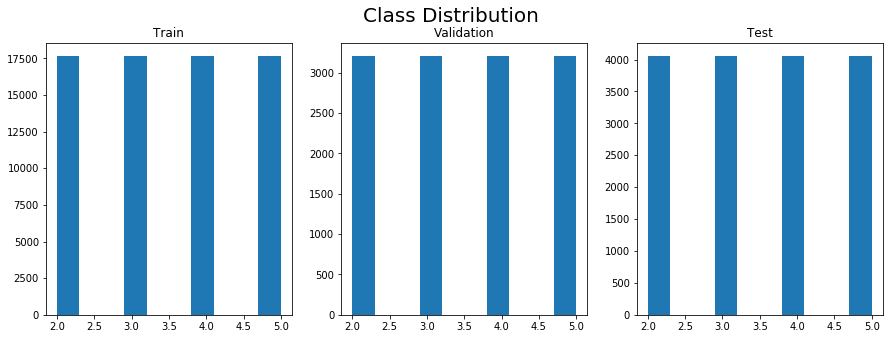

In [154]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,5))
y_train = np.concatenate(Y_train)
y_valid = np.concatenate(Y_valid)
y_test = np.concatenate(Y_test)

plt.subplot(1,3,1)
plt.hist(y_train)
plt.title("Train")
plt.subplot(1,3,2)
plt.hist(y_valid)
plt.title("Validation")
plt.subplot(1,3,3)
plt.hist(y_test)
plt.title("Test")
plt.suptitle("Class Distribution", fontsize=20)
plt.show()

## 2. Data Preprocessing

### 2.1. Data overview
First of all, let us gain some knowledge of our data by printing the amount of samples in training, validation and test sets.

In [45]:
# Number of samples in dataset
n1 = sum([len(x) for x in X_train])
n2 = sum([len(x) for x in X_valid])
n3 = sum([len(x) for x in X_test])
print("train:", n1)
print("valid:", n2)
print("test:", n3)
print("total:", n1+n2+n3)

train: 70672
valid: 12836
test: 16228
total: 99736


Another aspect to explore from the data is the mean images of each category. This can give us an intuition of the complexity of the classifier we aim to implement.

In [144]:
# Obtain mean image per each class
mu = [None,None,None,None]
n_samples = [0,0,0,0]

for i in range(len(Y_train)):
    for j in range(4):
        pos = Y_train[i]==j+2
        n_samples[j] += pos.sum()
        if mu[j] is not None:
            mu[j] += pos.sum()*np.mean(X_train[i][pos], axis=0)
        else:
            mu[j] = pos.sum()*np.mean(X_train[i][pos], axis=0)

# Average
for j in range(4):
    mu[j] /= n_samples[j] 

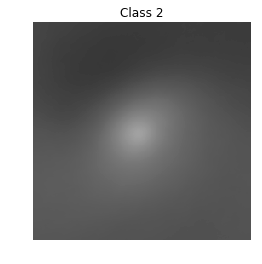

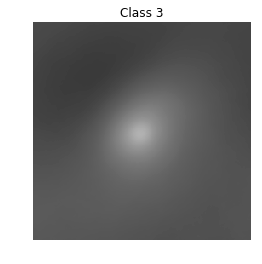

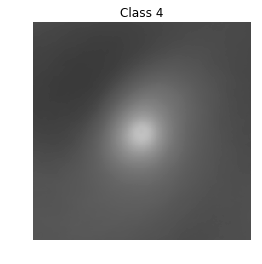

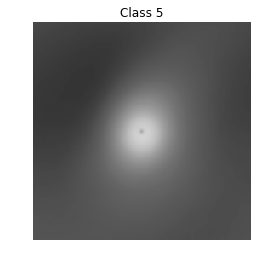

In [153]:
# Plot obtained mean images
for j in range(4):
    plt.imshow(mu[j], cmap="Greys", vmin=0, vmax=255)
    plt.title("Class " + str(j+2))
    plt.axis('off')
    plt.savefig('mean_class'+str(j)+'.eps')
    plt.show()

### 2.2. Load preprocess parameters
Note that to preprocess the images (centre and normalise) we require the preprocessing parameters. Hence, these parameters will depend on the dataset being used. In this experiments we use a dataset generated based on the years of the sequences. In particular, the trainig, validation and test datasets have been generated at sequence level. That is, images belonging to the same typhoon sequence find themselves only in one set. In addition, sequences from old typhoons have been used for training, while newer are used for testing. These parameters are found under `'../preprocessing_year.h5'`. 

We note that for both approaches 256x256 images have been used. These files, contain the following preprocessing parameters:

- Mean image: Image containing the mean for each pixel location.
- Pixel mean: Overal pixel intensity mean (scalar value).
- Pixel standard deviation: Overall pixel standard deviation (scalar value).
- Pixel maximum value: Overall maximum pixel intensity value (scalar value).
- Pixel minimum value: Overall minimum pixel intensity value (scalar value).

Depending on your needs, you may use `MeanImagePreprocessor` or`DefaultImagePreprocessor` to preprocess your data. Generation of these files is easy, and is done by `pyphoon.app.preprocess.generate_preprocess_params`. Set variable `generate_params` below to True to do so, however, the repository already provides precomputed preprocessing parameters.

In [7]:
generate_params = False
if generate_params:
    from pyphoon.app.preprocess import generate_preprocess_params
    generate_preprocess_params(X_train, "../preprocessing_year.h5")

For this task, we will use `MeanImagePreprocessor`, which uses the dataset mean image to centre the data and the minimum and maximum pixel values to normalise the images. To this end, we have previously computed these parameters and stored them under file `random.h5`. Note that the next step may take a while...

In [46]:
import h5py
# Define preprocessor
with h5py.File('../preprocessing_year.h5') as f:
    mean = f.get('image_mean').value
    scale_factor = f.get('max_value').value - f.get('min_value').value

### 2.3. Preprocessor
We define the preprocessing pipeline here. However, the preprocessing of the data is done in the data generator when training the model. This way, we reduce the memory requirements.

In [47]:
from pyphoon.app.preprocess import MeanImagePreprocessor

preprocessor = MeanImagePreprocessor(mean, scale_factor, add_axis=[3])

## 3. Model
In this section we will define our models architecture and will train it from scratch. Alternatively, you may refer to section 3.3 to load pretrained weights. However, make sure to define the model architecture first.

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, \
    Flatten, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 3.1. Model architecture
Now, time to define our model. We directly implement the final architecture, with the hyper-parameters that provided best result during the grid search.

In [ ]:
input_img = Input(shape=(128, 128, 1), name="in")
############################################################################
# Convolutional Layers
############################################################################
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv2d_1')(
    input_img)
x = Activation('relu', name='activation_1')(x)
x = BatchNormalization(name="batch_normalization_1")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_1')(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv2d_2')(x)
x = Activation('relu', name='activation_2')(x)
x = BatchNormalization(name="batch_normalization_2")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_2')(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv2d_3')(x)
x = Activation('relu', name='activation_3')(x)
x = BatchNormalization(name="batch_normalization_3")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_3')(x)

x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv2d_4')(x)
x = Activation('relu', name='activation_4')(x)
x = BatchNormalization(name="batch_normalization_4")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_4')(x)
############################################################################
# Dense Layers
############################################################################
x = Flatten()(x)

x = Dense(512, use_bias=True, name="dense_1")(x)
x = Activation('relu', name="activation_5")(x)
x = BatchNormalization(name="batch_normalization_5")(x)
x = Dropout(0.2, name="dropout_1")(x)

x = Dense(256, use_bias=True, name="dense_2")(x)
x = Activation('relu', name="activation_6")(x)
x = BatchNormalization(name="fc_bn2")(x)

############################################################################
# Output
############################################################################
x = Dense(4, use_bias=True, name="dense_3")(x)
x = Activation('softmax', name="out")(x)

############################################################################
# Modelshinjuku to asa
############################################################################
model = Model(input_img, x)

In [158]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    'accuracy'])

### 3.2 Callbacks
Before training, we will define some usefull callbacks to supervise the training process. One of the most usefull callbacks is [Tensorboard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard), which enables easy visualisation of loss and accuracy curves.

Make sure to use the following command to run the tensorboard client.

```
$ tensorboard --logdir=<path/to/log-directory> --port <port>
```

Once the model is training you may check its performance by navigating to `localhost:<port>`.

In [98]:
from pyphoon.app.callbacks import StoreModelWeights, OurTensorBoard, LossHistory

foldername = 'diumenge_year_8'
storeweights_callback = StoreModelWeights(foldername, naming="val_acc")
tensorboard_callback = OurTensorBoard(foldername)
loss_callback = LossHistory()

callbacks = [loss_callback, storeweights_callback, tensorboard_callback]

### 3.3 Training
Finally, To feed our model with input data we will use a data generator, provided by method `data_generator_from_chunklist` from `pyphoon.app.utils`.

In [ ]:
from pyphoon.app.utils import DataGeneratorFromChunklist

# Generator
batch_size = 32
generator = DataGeneratorFromChunklist(batch_sz=batch_size, 
                                       preprocess_algorithm=preprocessor.apply, 
                                       target_enc='ohe',
                                       crop=128
    )

# Number steps
n_steps_train = sum([np.ceil(len(x)/batch_size) for x in Y_train])
n_steps_valid = sum([np.ceil(len(x)/batch_size) for x in Y_valid])

# Number of full epochs, i.e. #times algorithm sees all the data
epochs = 10

# Train
model.fit_generator(
    generator=generator.feed(X_train, Y_train),
    steps_per_epoch=n_steps_train,
    validation_data=generator.feed(X_valid, Y_valid),
    validation_steps=n_steps_valid,
    epochs=epochs,
    callbacks=callbacks
)

### 3.4 Load pre-trained weights
Here we load the weights that provided the best performance and evaluate the performance on the test data. l.

In [159]:
model.load_weights('../weights.hdf5')

## 4. Results
### 4.1 Test accuracy
We evaluate the model that performed best on the validation set on the test set. This is the final performance of our model.

In [160]:
# Generator
batch_size = 32
generator = DataGeneratorFromChunklist(batch_sz=batch_size, 
                                       preprocess_algorithm=preprocessor.apply, 
                                       target_enc='ohe',
                                       crop=128)
# Number steps
n_steps = sum([np.ceil(len(x)/batch_size) for x in Y_test])

# Get predictions
y_pred = model.predict_generator(
    generator=generator.feed(X_test, Y_test, shuffle_batches=False, shuffle_samples=False),
    steps=n_steps
)
y_pred = np.argmax(y_pred, axis=1)

# Ground truth
y_true = (np.concatenate(Y_test) - 2).tolist()

# Test accuracy
acc_test = (np.array(y_true) == np.array(y_pred)).mean()
print("Accuracy on test set:", acc_test)

Accuracy on test set: 0.57825979788


### 4.2 Confusion Matrix, precision, recall
Now we take a closer look in an attempt to see if our model is biased towards some category.

In [161]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pd.DataFrame(confusion_matrix(y_true, y_pred), 
             columns=['predicted 2','predicted 3','predicted 4','predicted 5'], 
             index=['2', '3', '4', '5']
            )

,predicted 2,predicted 3,predicted 4,predicted 5
2,2876,1012,147,22
3,1082,1736,1037,202
4,239,1087,1865,866
5,37,278,835,2907


In [162]:
from sklearn.metrics import classification_report

# Get complete report
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.68      0.71      0.69      4057
        1.0       0.42      0.43      0.42      4057
        2.0       0.48      0.46      0.47      4057
        3.0       0.73      0.72      0.72      4057

avg / total       0.58      0.58      0.58     16228

